# Module 1 Load Data

In [1]:
import sys
from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf

## load table 

In [2]:
## load dataset & filter out missing data
# dbfile = pd.read_csv('./Data/vdjdb.slim.txt', sep='\t')
dbfile = pd.read_csv('./Data/VDJDB/vdjdb_full.txt', sep='\t')
# print(dbfile.columns)
dbfile = dbfile[['cdr3.alpha', 'cdr3.beta','antigen.epitope','antigen.species',"mhc.class"]]
print(dbfile.shape)
dbfile = dbfile.dropna(subset=['cdr3.alpha', 'cdr3.beta','antigen.epitope'])
print(dbfile.shape)
dbfile.head()

(60055, 5)
(29266, 5)


C:\Users\croco\AppData\Local\Temp\ipykernel_5352\3075150544.py:3: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  dbfile = pd.read_csv('./Data/VDJDB/vdjdb_full.txt', sep='\t')


,cdr3.alpha,cdr3.beta,antigen.epitope,antigen.species,mhc.class
0,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,HIV-1,MHCI
2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,FLKEKGGL,HIV-1,MHCI
3,CAVKASGSRLT,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,HIV-1,MHCI
4,CAYRPPGTYKYIF,CASSALASLNEQFF,FLKEKGGL,HIV-1,MHCI
5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,FLKEQGGL,HIV-1,MHCI


In [3]:
iedbfile = pd.read_csv('./Data/IEDB/tcell_receptor_table_export_1668026760.csv')
# print(iedbfile.columns)
# Chain 1 Full Sequence', 'Chain 1 Accession', 'Chain 1 CDR3 Curated',
#        'Chain 1 CDR3 Calculated'
iedbfile = iedbfile[['Chain 1 CDR3 Curated','Chain 2 CDR3 Curated',"Description","Organism"]]
print(iedbfile.shape)
iedbfile = iedbfile.dropna(subset=['Chain 1 CDR3 Curated','Chain 2 CDR3 Curated',"Description"])
iedbfile.Description = iedbfile.Description.str.split(' ').str[0]
iedbfile = iedbfile[~iedbfile.Description.str.contains('[^ARNDCQEGHILKMFPSTWYV]',na=False)]
print(iedbfile.shape)
iedbfile.head()

C:\Users\croco\AppData\Local\Temp\ipykernel_5352\605436328.py:1: DtypeWarning: Columns (8,10,11,13,15,16,17,18,19,20,21,22,23,24,25,30,31,36,37,42,44,45,46,47,48,49,50,51,52,53,54,59,60,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  iedbfile = pd.read_csv('./Data/IEDB/tcell_receptor_table_export_1668026760.csv')


(205824, 4)
(25927, 4)


,Chain 1 CDR3 Curated,Chain 2 CDR3 Curated,Description,Organism
0,IVVRSSNTGKLI,ASSQDRDTQY,VMAPRTLIL,Homo sapiens (human)
80,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF,LLFGYPVYV,Human T-cell leukemia virus type I (Human T ce...
82,CAVTTDSWGKLQF,CASRPGLMSAQPEQYF,LLFGYPVYV,Human T-cell leukemia virus type I (Human T ce...
109,CAVRPTSGGSYIPTF,CASSYVGNTGELFF,SLLMWITQC,Homo sapiens (human)
202,TVYGGATNKLI,SARGGSYNSPLH,LSRFSWGAEGQRPGFGYGG,Homo sapiens (human)


In [4]:
# mixeddb = 

## Encoding & split sets

In [5]:
from functions import load
# from functions.load import enc_list_bl_max_len, positional_coding, blosum50_20aa 

In [6]:
from importlib import reload
# reload(load)

In [7]:
print(dbfile.head(n=2)["cdr3.alpha"])
load.enc_list_bl_max_len(dbfile.head(n=2)["cdr3.alpha"],load.blosum50_20aa,30).shape

0     CIVRAPGRADMRF
2    CAVPSGAGSYQLTF
Name: cdr3.alpha, dtype: object


(2, 30, 20)

In [8]:
tokens = load.blosum50_20aa.keys()

tokens = list(tokens)
tokens.insert(0, '.')
tk_dict = defaultdict(lambda: None)
for idx in range(len(tokens)):
    tk_dict[tokens[idx]]=idx

In [9]:
load.positional_coding(dbfile.head(n=52)["cdr3.alpha"],tk_dict,30).shape
load.positional_coding(iedbfile.head(n=52)["Chain 1 CDR3 Curated"],tk_dict,30).shape

(52, 30)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(dbfile[dbfile['antigen.epitope'].str.len()<=12], shuffle=True ,test_size=0.2)

In [12]:
ept_train = load.positional_coding(train['antigen.epitope'], tk_dict, 12)
tcra_train = load.positional_coding(train["cdr3.alpha"], tk_dict, 30)
tcrb_train = load.positional_coding(train["cdr3.beta"], tk_dict, 30)
ept_train_lb = np.roll(ept_train, 1)
tcr_train = np.concatenate((tcra_train,tcrb_train),axis=1)
print(ept_train.shape, tcra_train.shape, tcrb_train.shape,tcr_train.shape)
ept_test = load.positional_coding(test['antigen.epitope'], tk_dict, 12)
tcra_test = load.positional_coding(test["cdr3.alpha"], tk_dict, 30)
tcrb_test = load.positional_coding(test["cdr3.beta"], tk_dict, 30)
tcr_test = np.concatenate((tcra_test,tcrb_test),axis=1)
ept_test_lb = np.roll(ept_test, 1)

(23161, 12) (23161, 30) (23161, 30) (23161, 60)


In [13]:
tcr_train = tf.convert_to_tensor(tcr_train)
# tcr_train_lb = tf.convert_to_tensor(tcr_train_lb)
# tcra_train = tf.convert_to_tensor(tcra_train)
# tcrb_train = tf.convert_to_tensor(tcrb_train)
ept_train = tf.convert_to_tensor(ept_train)
ept_train_lb = tf.convert_to_tensor(ept_train_lb)
# tcr_train = tf.convert_to_tensor(numeric_features)
tcr_test = tf.convert_to_tensor(tcr_test)
# tcr_test_lb = tf.convert_to_tensor(tcr_test_lb)
# tcra_test = tf.convert_to_tensor(tcra_test)
# tcrb_test = tf.convert_to_tensor(tcrb_test)
ept_test = tf.convert_to_tensor(ept_test)
ept_test_lb = tf.convert_to_tensor(ept_test_lb)

# Model Input

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [17]:
from functions import model
# reload(model)

In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_TOKENS = 32


def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [19]:
dataset = tf.data.Dataset.from_tensor_slices(((tcr_train,ept_train),ept_train_lb))
dataset = make_batches(dataset)
dataset_val = tf.data.Dataset.from_tensor_slices(((tcr_test, ept_test),ept_test_lb))
dataset_val = make_batches(dataset_val)

In [20]:
for (ept, tcr), tcr_lb in dataset.take(2):
  break

print(ept.shape)
print(tcr.shape)
print(tcr_lb.shape)

(64, 60)
(64, 12)
(64, 12)


In [21]:
print(tcr[0][:10])
print(tcr_lb[0][:10])

embed_tcr = model.PositionalEmbedding(vocab_size=21, d_model=512)
embed_ept = model.PositionalEmbedding(vocab_size=21, d_model=512)

tcr_emb = embed_tcr(tcr)
ept_emb = embed_ept(ept)
print(tcr_emb._keras_mask)

tf.Tensor([12. 11.  8.  8.  1. 11.  6.  1. 12.  0.], shape=(10,), dtype=float64)
tf.Tensor([ 0. 12. 11.  8.  8.  1. 11.  6.  1. 12.], shape=(10,), dtype=float64)
tf.Tensor(
[[ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True  True  True False False]
 [ True  True  True  True  True  True  True  True  True False False False]
 [

In [22]:
sample_encoder = model.Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=21)

sample_encoder_output = sample_encoder(tcr, training=False)
print(tcr.shape)
print(sample_encoder_output.shape)

(64, 12)
(64, 12, 512)


In [23]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [24]:
transformer = model.Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=np.int64(21),
    target_vocab_size=np.int64(21),
    dropout_rate=dropout_rate)

In [25]:
output = transformer((ept,tcr))

print(tcr.shape)
print(ept.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 12)
(64, 60)
(64, 12, 21)
(64, 8, 12, 60)


In [26]:
output[1,1,:]

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([-0.22654732,  2.7606866 ,  0.4078293 ,  0.29853964, -0.48706892,
       -3.999951  , -1.5115181 , -0.6058616 , -1.7489079 , -1.2016349 ,
       -1.105646  , -1.3599912 ,  2.6185935 , -0.4368922 ,  0.04865283,
        2.7802079 , -0.69060826,  2.127555  , -3.830478  ,  1.2093334 ,
       -0.19694869], dtype=float32)>

Text(0.5, 0, 'Train Step')

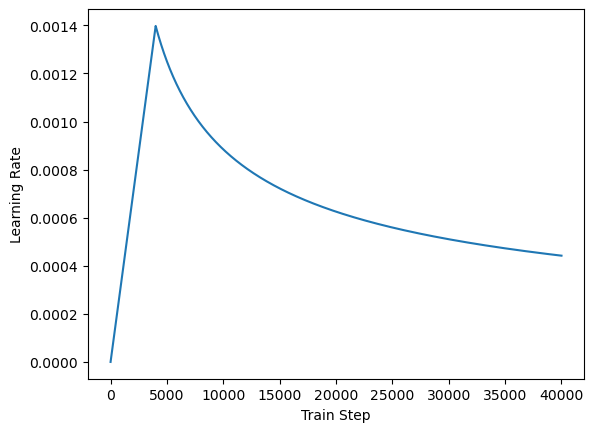

In [27]:
learning_rate = model.CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [28]:
transformer.compile(
    loss=model.masked_loss,
    optimizer=optimizer,
    metrics=[model.masked_accuracy])

In [29]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2641536   
                                                                 
 decoder (Decoder)           multiple                  4752512   
                                                                 
 dense_24 (Dense)            multiple                  2709      
                                                                 
Total params: 7,396,757
Trainable params: 7,396,757
Non-trainable params: 0
_________________________________________________________________


In [30]:
transformer.fit(dataset,
                epochs=20,
                validation_data=dataset_val)

Epoch 1/20
362/362 [==============================] - 33s 72ms/step - loss: 1.1354 - masked_accuracy: 0.6963 - val_loss: 0.0812 - val_masked_accuracy: 0.9790
Epoch 2/20
362/362 [==============================] - 25s 68ms/step - loss: 0.0531 - masked_accuracy: 0.9871 - val_loss: 0.0072 - val_masked_accuracy: 0.9981
Epoch 3/20
362/362 [==============================] - 25s 68ms/step - loss: 0.0191 - masked_accuracy: 0.9950 - val_loss: 0.0023 - val_masked_accuracy: 0.9994
Epoch 4/20
362/362 [==============================] - 25s 68ms/step - loss: 0.0145 - masked_accuracy: 0.9962 - val_loss: 0.0059 - val_masked_accuracy: 0.9986
Epoch 5/20
362/362 [==============================] - 25s 68ms/step - loss: 0.0161 - masked_accuracy: 0.9959 - val_loss: 0.0040 - val_masked_accuracy: 0.9991
Epoch 6/20
362/362 [==============================] - 25s 68ms/step - loss: 0.0187 - masked_accuracy: 0.9954 - val_loss: 0.0052 - val_masked_accuracy: 0.9986
Epoch 7/20
362/362 [==============================] 